### Part 01. Load packages and libs

In [1]:
import os
import time
import warnings
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

### Part 02. Writing a custom dataset for Blood Cell Segmemtation dataset, write data loader to load data for train model

In [2]:
TRAIN_IMG_DIR = "datasets/kvasir_capsule/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_capsule/train/masks"
VAL_IMG_DIR = "datasets/kvasir_capsule/test/images"
VAL_MASK_DIR = "datasets/kvasir_capsule/test/masks"

In [3]:
class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)  # l -> grayscale
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

In [4]:
def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [5]:
train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [6]:
BATCH_SIZE = 2

train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

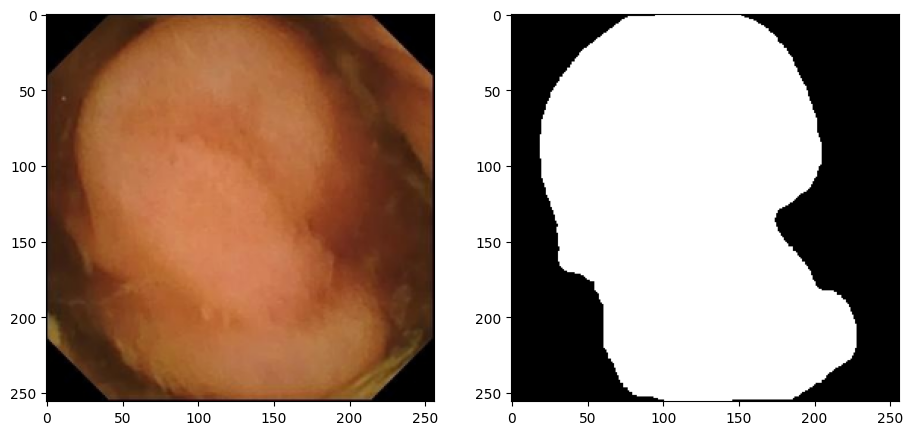

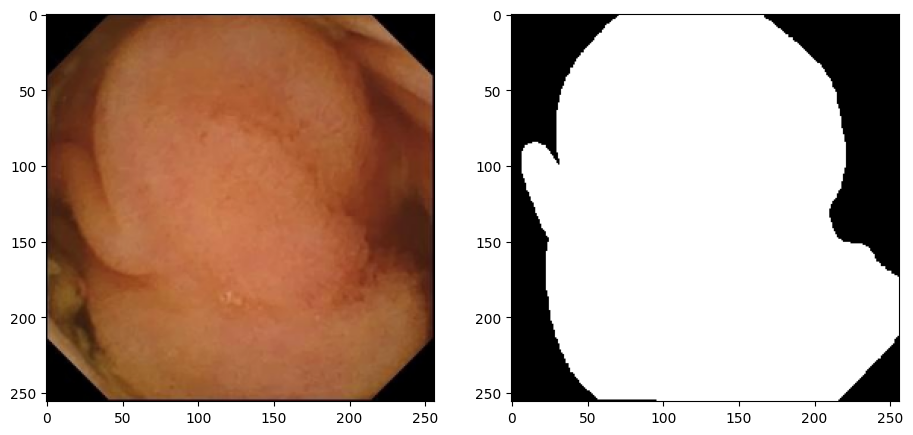

In [7]:
def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")


show_transformed(val_loader)

In [8]:
train_loader.dataset[0][0].shape
train_loader.dataset[0][1].shape

torch.Size([256, 256])

In [9]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE

class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()

        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels,
                      kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(mid_channels, out_channels,
                      kernel_size=3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [11]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [12]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='bilinear', align_corners=True)
            self.conb = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [13]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.input = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)

        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512)

        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)

        self.outc = OutConv(32, n_classes)

    def forward(self, x):

        x1 = self.input(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        output = self.outc(x)
        return output

    def use_checkpointing(self):
        self.input = torch.utils.checkpoint(self.input)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [15]:
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_loss = []
train_dice = []

def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [16]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,216
              ReLU-4         [-1, 32, 256, 256]               0
        DoubleConv-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
              ReLU-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,864
             ReLU-10         [-1, 64, 128, 128]               0
       DoubleConv-11         [-1, 64, 128, 128]               0
             Down-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

In [17]:
model

UNet(
  (input): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64,

In [18]:
print(model)

UNet(
  (input): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64,

In [19]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
        # with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the UNET model is: {training_time:.2f} seconds")

Epoch: 1/32


100%|██████████| 22/22 [00:05<00:00,  4.16it/s, diceloss=1.06, iou=0.427]


Epoch: 1/32, IoU score: 0.40314753489060834
Epoch: 1/32, Total num_correct/num_pixels: 428765/720896 => 0.5947667956352234
Epoch: 1/32, Dice score: 0.7359324075643563
Epoch: 2/32


100%|██████████| 22/22 [00:05<00:00,  4.23it/s, diceloss=1.19, iou=0.523] 


Epoch: 2/32, IoU score: 0.4492809203538028
Epoch: 2/32, Total num_correct/num_pixels: 428765/720896 => 0.5947667956352234
Epoch: 2/32, Dice score: 0.7359324075643563
Epoch: 3/32


100%|██████████| 22/22 [00:05<00:00,  4.25it/s, diceloss=0.957, iou=0.547]


Epoch: 3/32, IoU score: 0.5780726996335116
Epoch: 3/32, Total num_correct/num_pixels: 428765/720896 => 0.5947667956352234
Epoch: 3/32, Dice score: 0.7359324075643563
Epoch: 4/32


100%|██████████| 22/22 [00:05<00:00,  4.24it/s, diceloss=0.717, iou=0.637]


Epoch: 4/32, IoU score: 0.6072019135410135
Epoch: 4/32, Total num_correct/num_pixels: 428765/720896 => 0.5947667956352234
Epoch: 4/32, Dice score: 0.7359324075643563
Epoch: 5/32


100%|██████████| 22/22 [00:05<00:00,  4.23it/s, diceloss=0.793, iou=0.625]


Epoch: 5/32, IoU score: 0.6470451680096713
Epoch: 5/32, Total num_correct/num_pixels: 533016/720896 => 0.7393798828125
Epoch: 5/32, Dice score: 0.8081944817809457
Epoch: 6/32


100%|██████████| 22/22 [00:05<00:00,  4.29it/s, diceloss=0.402, iou=0.767]


Epoch: 6/32, IoU score: 0.6580159149386666
Epoch: 6/32, Total num_correct/num_pixels: 597782/720896 => 0.8292208909988403
Epoch: 6/32, Dice score: 0.8592706995834345
Epoch: 7/32


100%|██████████| 22/22 [00:05<00:00,  4.30it/s, diceloss=0.77, iou=0.602] 


Epoch: 7/32, IoU score: 0.7095593024383892
Epoch: 7/32, Total num_correct/num_pixels: 594268/720896 => 0.8243464231491089
Epoch: 7/32, Dice score: 0.8595748031599162
Epoch: 8/32


100%|██████████| 22/22 [00:05<00:00,  4.30it/s, diceloss=0.446, iou=0.763]


Epoch: 8/32, IoU score: 0.7147480926730416
Epoch: 8/32, Total num_correct/num_pixels: 560137/720896 => 0.777001142501831
Epoch: 8/32, Dice score: 0.8302540388265844
Epoch: 9/32


100%|██████████| 22/22 [00:05<00:00,  4.26it/s, diceloss=0.607, iou=0.649]


Epoch: 9/32, IoU score: 0.6615536944432692
Epoch: 9/32, Total num_correct/num_pixels: 589025/720896 => 0.8170735239982605
Epoch: 9/32, Dice score: 0.8398583558322614
Epoch: 10/32


100%|██████████| 22/22 [00:05<00:00,  4.29it/s, diceloss=0.472, iou=0.715]


Epoch: 10/32, IoU score: 0.7005495158108798
Epoch: 10/32, Total num_correct/num_pixels: 594431/720896 => 0.8245725035667419
Epoch: 10/32, Dice score: 0.8589776201374335
Epoch: 11/32


100%|██████████| 22/22 [00:05<00:00,  4.26it/s, diceloss=0.499, iou=0.698]


Epoch: 11/32, IoU score: 0.7203737280585549
Epoch: 11/32, Total num_correct/num_pixels: 601491/720896 => 0.8343658447265625
Epoch: 11/32, Dice score: 0.8653831916355005
Epoch: 12/32


100%|██████████| 22/22 [00:05<00:00,  4.23it/s, diceloss=0.645, iou=0.634]


Epoch: 12/32, IoU score: 0.7243160497058522
Epoch: 12/32, Total num_correct/num_pixels: 596619/720896 => 0.8276076316833496
Epoch: 12/32, Dice score: 0.8619283044987324
Epoch: 13/32


100%|██████████| 22/22 [00:05<00:00,  3.89it/s, diceloss=0.406, iou=0.758]


Epoch: 13/32, IoU score: 0.7245907946066423
Epoch: 13/32, Total num_correct/num_pixels: 615415/720896 => 0.8536807298660278
Epoch: 13/32, Dice score: 0.8795145334115674
Epoch: 14/32


100%|██████████| 22/22 [00:05<00:00,  4.07it/s, diceloss=0.691, iou=0.68] 


Epoch: 14/32, IoU score: 0.7347608317028392
Epoch: 14/32, Total num_correct/num_pixels: 601989/720896 => 0.8350566625595093
Epoch: 14/32, Dice score: 0.8684600760366049
Epoch: 15/32


100%|██████████| 22/22 [00:05<00:00,  4.19it/s, diceloss=0.349, iou=0.809]


Epoch: 15/32, IoU score: 0.7326855578205802
Epoch: 15/32, Total num_correct/num_pixels: 624630/720896 => 0.8664634227752686
Epoch: 15/32, Dice score: 0.8897344754937798
Epoch: 16/32


100%|██████████| 22/22 [00:05<00:00,  4.11it/s, diceloss=0.284, iou=0.795]


Epoch: 16/32, IoU score: 0.7517750290307131
Epoch: 16/32, Total num_correct/num_pixels: 634533/720896 => 0.8802005052566528
Epoch: 16/32, Dice score: 0.9020229794605618
Epoch: 17/32


100%|██████████| 22/22 [00:05<00:00,  4.04it/s, diceloss=0.36, iou=0.798] 


Epoch: 17/32, IoU score: 0.7663497410037301
Epoch: 17/32, Total num_correct/num_pixels: 649299/720896 => 0.9006833434104919
Epoch: 17/32, Dice score: 0.9180236686473641
Epoch: 18/32


100%|██████████| 22/22 [00:05<00:00,  4.01it/s, diceloss=0.367, iou=0.765]


Epoch: 18/32, IoU score: 0.7790534387935292
Epoch: 18/32, Total num_correct/num_pixels: 657936/720896 => 0.9126642942428589
Epoch: 18/32, Dice score: 0.9287253803645763
Epoch: 19/32


100%|██████████| 22/22 [00:05<00:00,  3.94it/s, diceloss=0.544, iou=0.704]


Epoch: 19/32, IoU score: 0.7898429063233462
Epoch: 19/32, Total num_correct/num_pixels: 643184/720896 => 0.8922008275985718
Epoch: 19/32, Dice score: 0.9115264323478068
Epoch: 20/32


100%|██████████| 22/22 [00:05<00:00,  3.97it/s, diceloss=0.444, iou=0.771]


Epoch: 20/32, IoU score: 0.8058871491388842
Epoch: 20/32, Total num_correct/num_pixels: 658216/720896 => 0.9130526781082153
Epoch: 20/32, Dice score: 0.9276117728496033
Epoch: 21/32


100%|██████████| 22/22 [00:05<00:00,  4.03it/s, diceloss=0.204, iou=0.877]


Epoch: 21/32, IoU score: 0.815853479233655
Epoch: 21/32, Total num_correct/num_pixels: 659035/720896 => 0.9141887426376343
Epoch: 21/32, Dice score: 0.9311303336580219
Epoch: 22/32


100%|██████████| 22/22 [00:05<00:00,  4.04it/s, diceloss=0.421, iou=0.816]


Epoch: 22/32, IoU score: 0.830916087735783
Epoch: 22/32, Total num_correct/num_pixels: 650969/720896 => 0.9029998779296875
Epoch: 22/32, Dice score: 0.9194736039492961
Epoch: 23/32


100%|██████████| 22/22 [00:05<00:00,  4.00it/s, diceloss=0.285, iou=0.84] 


Epoch: 23/32, IoU score: 0.8280726183544506
Epoch: 23/32, Total num_correct/num_pixels: 663072/720896 => 0.9197887182235718
Epoch: 23/32, Dice score: 0.9350653634193642
Epoch: 24/32


100%|██████████| 22/22 [00:05<00:00,  3.97it/s, diceloss=0.336, iou=0.815]


Epoch: 24/32, IoU score: 0.8423907512968237
Epoch: 24/32, Total num_correct/num_pixels: 663031/720896 => 0.919731855392456
Epoch: 24/32, Dice score: 0.9344314954555039
Epoch: 25/32


100%|██████████| 22/22 [00:05<00:00,  3.93it/s, diceloss=0.321, iou=0.837]


Epoch: 25/32, IoU score: 0.8336104344237935
Epoch: 25/32, Total num_correct/num_pixels: 661088/720896 => 0.9170365929603577
Epoch: 25/32, Dice score: 0.9316026636710114
Epoch: 26/32


100%|██████████| 22/22 [00:05<00:00,  3.99it/s, diceloss=0.455, iou=0.8]  


Epoch: 26/32, IoU score: 0.8418025482784618
Epoch: 26/32, Total num_correct/num_pixels: 636815/720896 => 0.8833659887313843
Epoch: 26/32, Dice score: 0.9049838160177656
Epoch: 27/32


100%|██████████| 22/22 [00:05<00:00,  3.92it/s, diceloss=0.214, iou=0.871]


Epoch: 27/32, IoU score: 0.8277251693335447
Epoch: 27/32, Total num_correct/num_pixels: 673284/720896 => 0.9339544177055359
Epoch: 27/32, Dice score: 0.9432873726877313
Epoch: 28/32


100%|██████████| 22/22 [00:05<00:00,  3.93it/s, diceloss=0.428, iou=0.711]


Epoch: 28/32, IoU score: 0.8128861107609489
Epoch: 28/32, Total num_correct/num_pixels: 636914/720896 => 0.8835033178329468
Epoch: 28/32, Dice score: 0.9027548733490051
Epoch: 29/32


100%|██████████| 22/22 [00:05<00:00,  3.90it/s, diceloss=0.244, iou=0.828]


Epoch: 29/32, IoU score: 0.7838498624888334
Epoch: 29/32, Total num_correct/num_pixels: 671140/720896 => 0.930980384349823
Epoch: 29/32, Dice score: 0.945060490626482
Epoch: 30/32


100%|██████████| 22/22 [00:05<00:00,  3.90it/s, diceloss=0.459, iou=0.783]


Epoch: 30/32, IoU score: 0.8394621285525236
Epoch: 30/32, Total num_correct/num_pixels: 671450/720896 => 0.9314103722572327
Epoch: 30/32, Dice score: 0.9445956916454599
Epoch: 31/32


100%|██████████| 22/22 [00:05<00:00,  3.91it/s, diceloss=0.375, iou=0.784]


Epoch: 31/32, IoU score: 0.8526294475251978
Epoch: 31/32, Total num_correct/num_pixels: 668943/720896 => 0.9279327392578125
Epoch: 31/32, Dice score: 0.9416983596868331
Epoch: 32/32


100%|██████████| 22/22 [00:05<00:00,  3.92it/s, diceloss=0.453, iou=0.832]

Epoch: 32/32, IoU score: 0.8562562438574705
Epoch: 32/32, Total num_correct/num_pixels: 661090/720896 => 0.9170393943786621
Epoch: 32/32, Dice score: 0.9330460648989005
done ..
The training time of the UNET model is: 176.80 seconds


In [20]:
print(train_loss)

[1.1018237363208423, 1.0399169596758755, 0.8553748997774991, 0.7984871186993339, 0.6986709318377755, 0.637780327688564, 0.5697516636414961, 0.537969866936857, 0.6491884155706926, 0.560522586107254, 0.5283203680406917, 0.5194098962978884, 0.5074258609251543, 0.4921013198115609, 0.5005243000659075, 0.4467270916158503, 0.42646563865921716, 0.4118807153268294, 0.3884856822815808, 0.3547872250730341, 0.33618089150298724, 0.3177367381074212, 0.31863001598553226, 0.29117701202630997, 0.3043574155731635, 0.30500058829784393, 0.305298352106051, 0.37158709087155084, 0.37473929673433304, 0.2967821264808828, 0.2673754942688075, 0.26879859647967597]


In [21]:
print(train_iou)

[0.40314753489060834, 0.4492809203538028, 0.5780726996335116, 0.6072019135410135, 0.6470451680096713, 0.6580159149386666, 0.7095593024383892, 0.7147480926730416, 0.6615536944432692, 0.7005495158108798, 0.7203737280585549, 0.7243160497058522, 0.7245907946066423, 0.7347608317028392, 0.7326855578205802, 0.7517750290307131, 0.7663497410037301, 0.7790534387935292, 0.7898429063233462, 0.8058871491388842, 0.815853479233655, 0.830916087735783, 0.8280726183544506, 0.8423907512968237, 0.8336104344237935, 0.8418025482784618, 0.8277251693335447, 0.8128861107609489, 0.7838498624888334, 0.8394621285525236, 0.8526294475251978, 0.8562562438574705]


In [22]:
print(train_dice)

[tensor(0.7359, device='cuda:0', dtype=torch.float64), tensor(0.7359, device='cuda:0', dtype=torch.float64), tensor(0.7359, device='cuda:0', dtype=torch.float64), tensor(0.7359, device='cuda:0', dtype=torch.float64), tensor(0.8082, device='cuda:0', dtype=torch.float64), tensor(0.8593, device='cuda:0', dtype=torch.float64), tensor(0.8596, device='cuda:0', dtype=torch.float64), tensor(0.8303, device='cuda:0', dtype=torch.float64), tensor(0.8399, device='cuda:0', dtype=torch.float64), tensor(0.8590, device='cuda:0', dtype=torch.float64), tensor(0.8654, device='cuda:0', dtype=torch.float64), tensor(0.8619, device='cuda:0', dtype=torch.float64), tensor(0.8795, device='cuda:0', dtype=torch.float64), tensor(0.8685, device='cuda:0', dtype=torch.float64), tensor(0.8897, device='cuda:0', dtype=torch.float64), tensor(0.9020, device='cuda:0', dtype=torch.float64), tensor(0.9180, device='cuda:0', dtype=torch.float64), tensor(0.9287, device='cuda:0', dtype=torch.float64), tensor(0.9115, device='cuda

In [23]:
train_dice = [t.cpu().item() for t in train_dice]

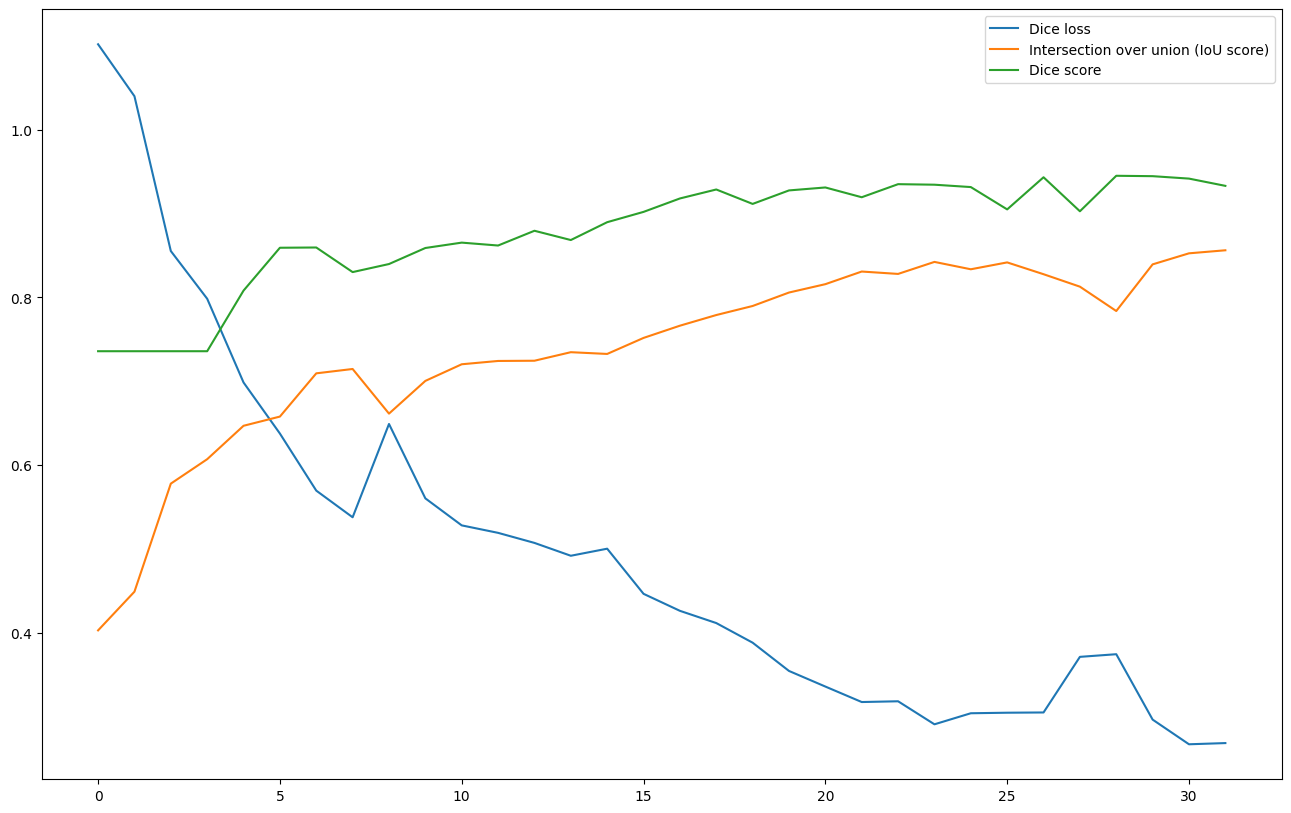

In [24]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [25]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou

avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 6/6 [00:00<00:00, 39.63it/s]

Average Dice Score: 0.9330
Average IoU Score: 0.5238


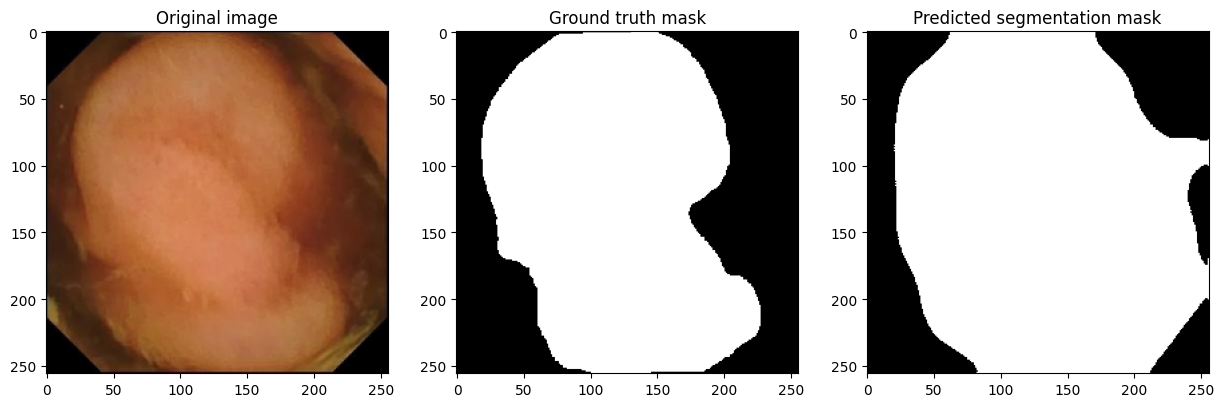

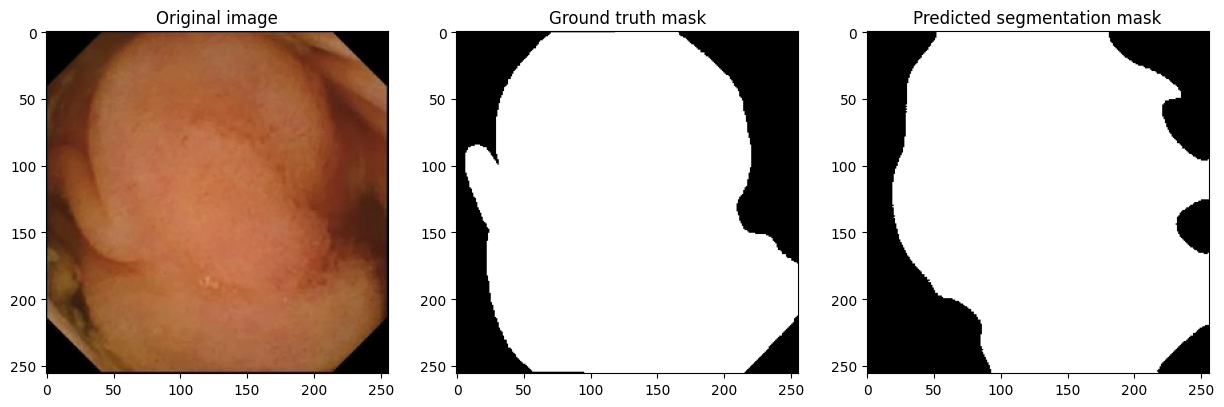

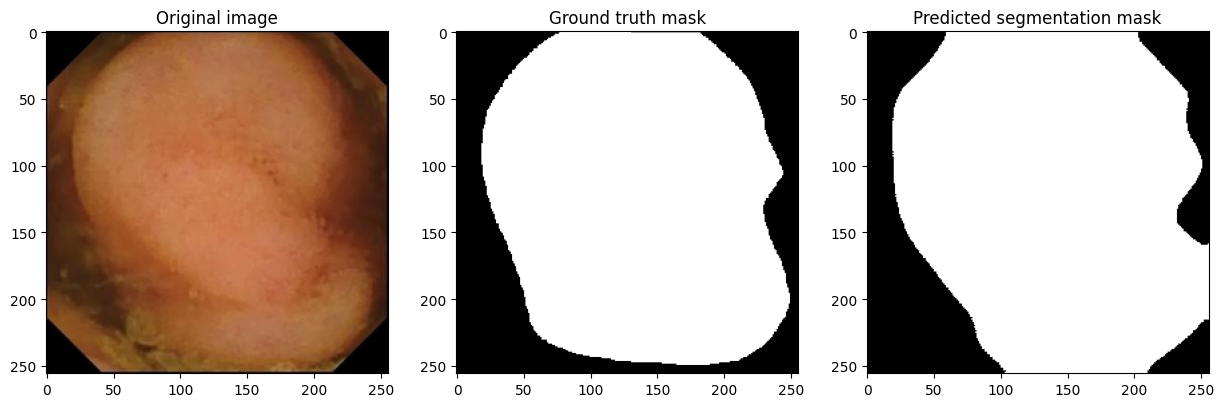

In [26]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                plt.subplot(1, 3, 2)
                plt.title("Ground truth mask")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                plt.subplot(1, 3, 3)
                plt.title("Predicted segmentation mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break

visualize_predictions(model, val_loader, DEVICE)

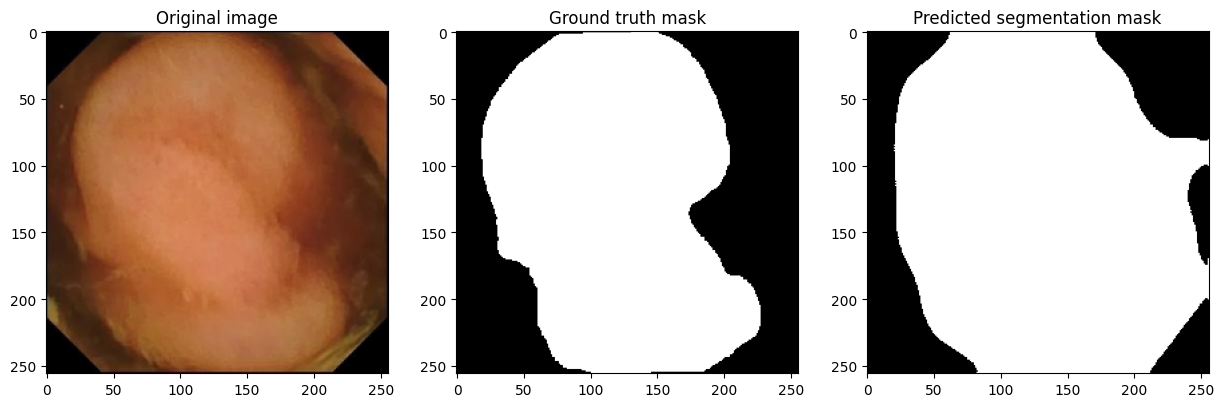

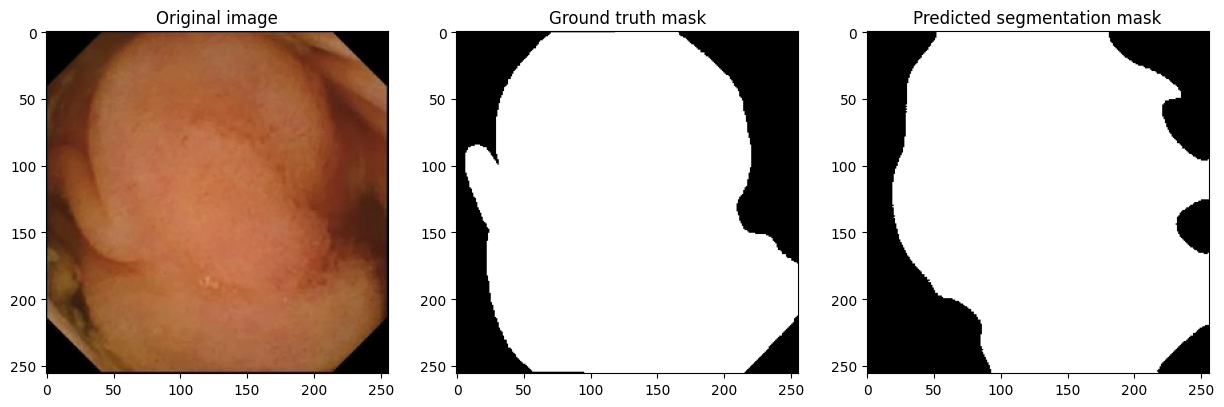

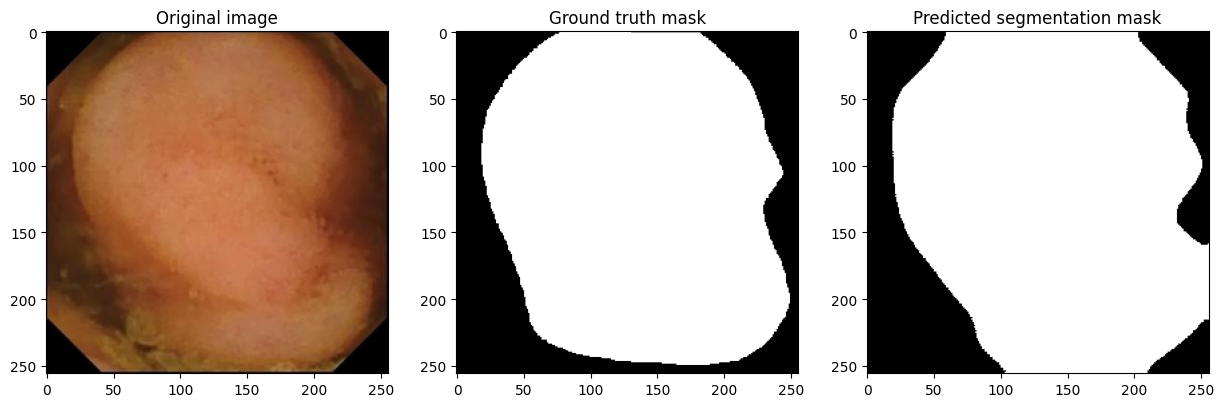

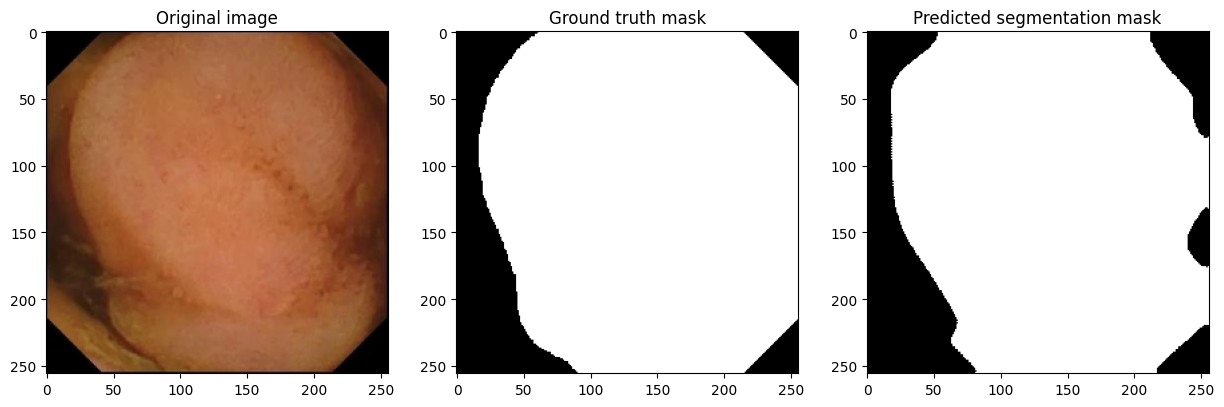

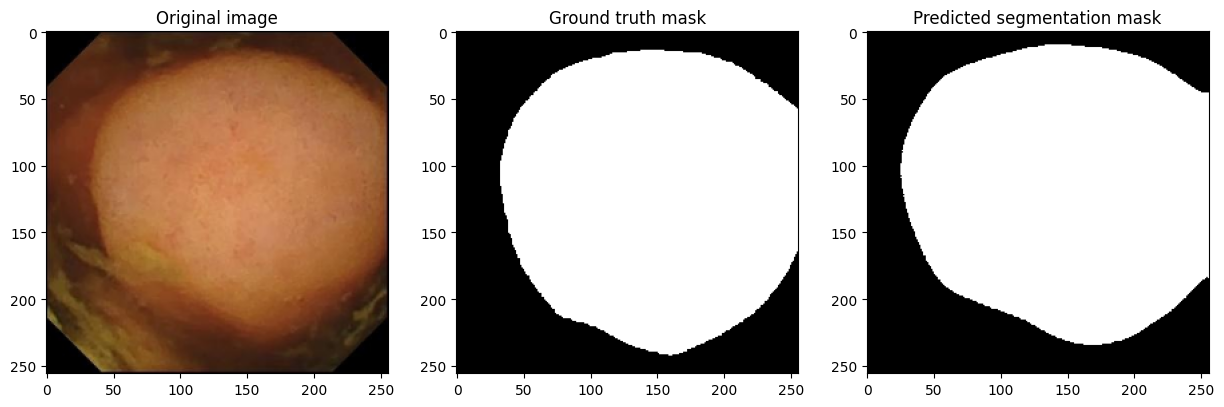

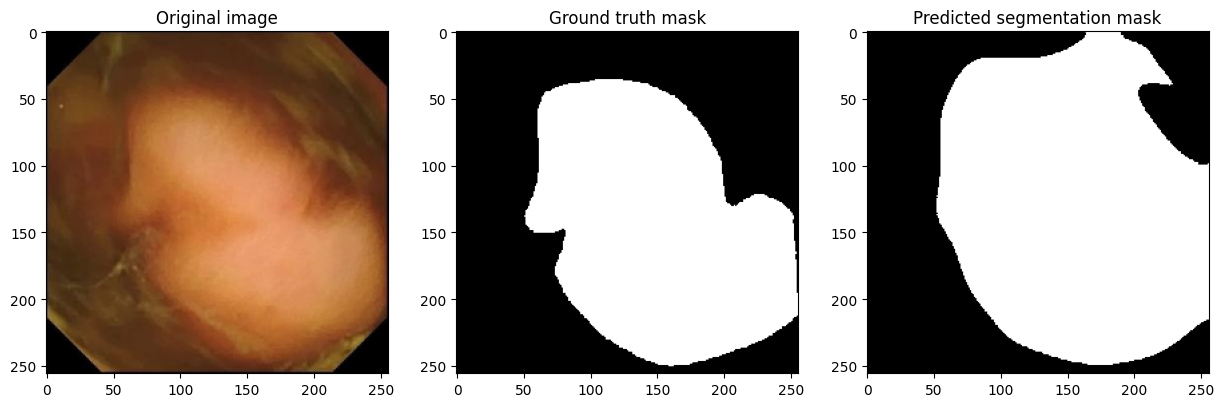

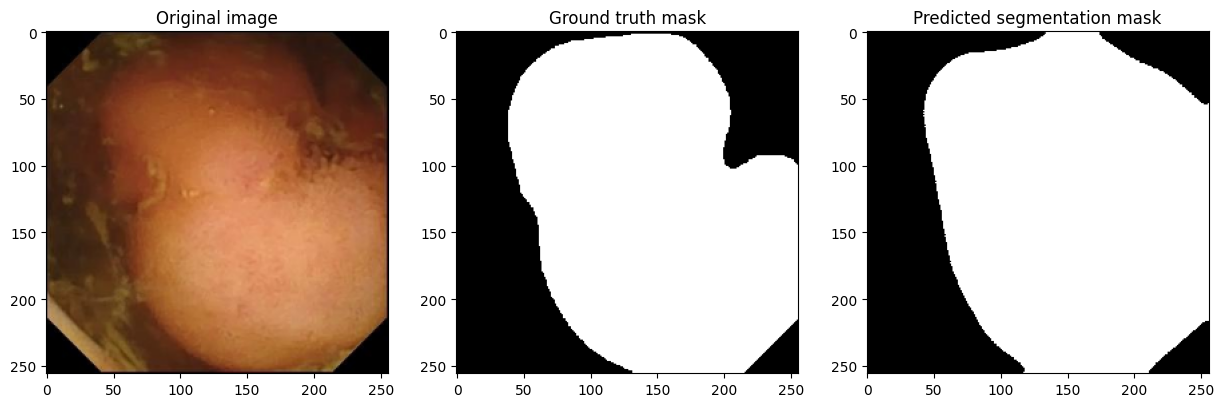

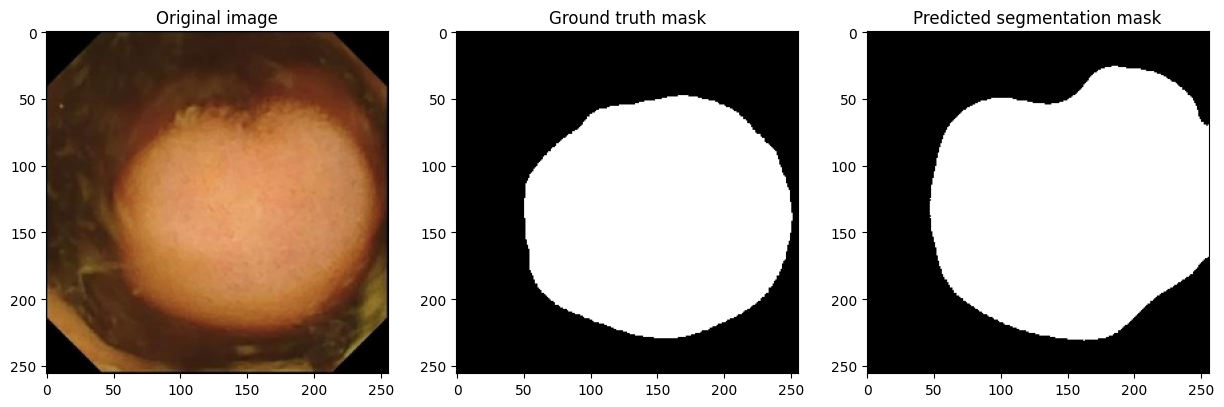

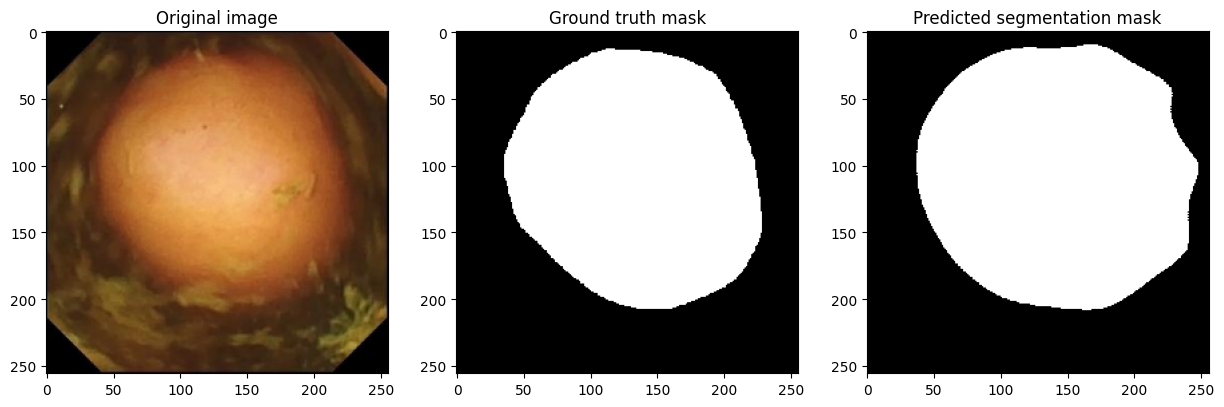

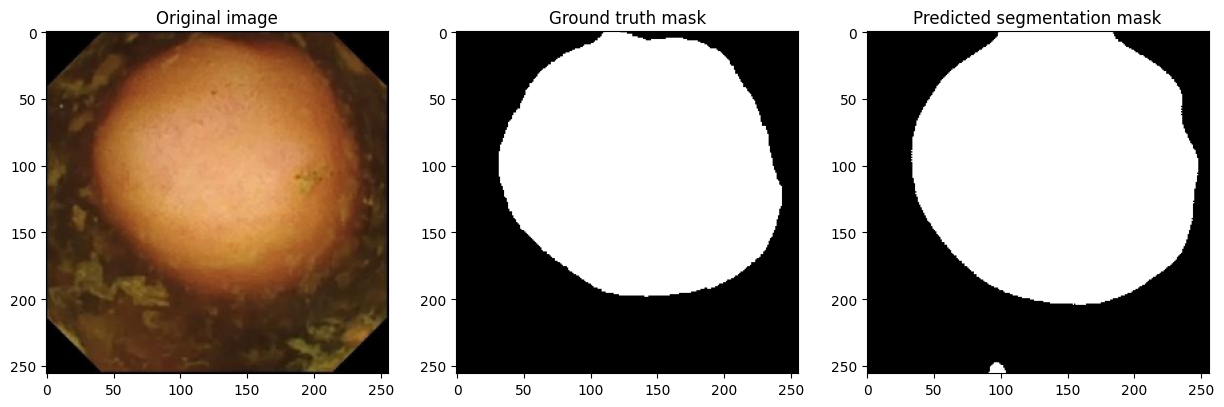

In [27]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)

In [28]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=50)

In [29]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=100)